<a href="https://colab.research.google.com/github/Hotckiss/DUL/blob/hw2/hw2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import ModuleList
from torch.distributions import Normal, MultivariateNormal
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

In [0]:
def sample_data():
  count = 100000
  rand = np.random.RandomState(0)
  a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
  -np.sin(np.linspace(0, np.pi, count // 3))]

  c += rand.randn(*c.shape) * 0.2
  data_x = np.concatenate([a, b, c], axis=0)
  data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
  perm = rand.permutation(len(data_x))
  return data_x[perm], data_y[perm]

In [0]:
X, y  = sample_data()

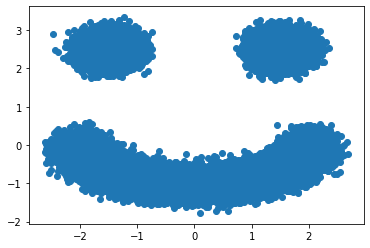

In [17]:
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [0]:
def loss_(y):
    return -torch.mean(torch.log(y)) / 2

In [0]:
def plot_loss(loss_train, loss_val):
  plt.plot(loss_train, label = "train")
  plt.plot(loss_val, label = "validate")
  plt.legend()
  plt.show()

In [0]:
class MyFlow(nn.Module):
    def __init__(self, k=8):
        super(MyFlow, self).__init__()
        self.k = k
        self.pi1_ = nn.Parameter(torch.randn(k))
        self.softmax = nn.Softmax(dim=-1)
        self.mu1_ = nn.Parameter(torch.randn(k))
        self.sigma1_ = nn.Parameter(torch.randn(k))

        self.hidden = nn.Sequential(nn.Linear(1, 128), nn.ReLU())
        self.pi2_ = nn.Sequential(nn.Linear(128, self.k), nn.Softmax(dim=-1))
        self.mu2_ = nn.Linear(128, self.k)
        self.sigma2_ = nn.Linear(128, self.k)
    
    def params2(self, x):
        h = self.hidden(x)
        
        return self.pi2_(h), self.mu2_(h), torch.abs(self.sigma2_(h))

    def params(self, x):
        x1, x2 = x[:, :1], x[:, 1:]
        self.batch = x1.shape[0]

        pi1, mu1, sigma1 = self.softmax(self.pi1_.repeat(self.batch, 1)), self.mu1_.repeat(self.batch, 1), torch.abs(self.sigma1_.repeat(self.batch, 1))

        h = self.hidden(x1)
        pi2, mu2, sigma2 = self.pi2_(h), self.mu2_(h), torch.abs(self.sigma2_(h))
      
        return pi1, mu1, sigma1, pi2, mu2, sigma2
    
    def forward(self, x):
      x1, x2 = x[:, :1],x[:, 1:]
      self.batch = x1.shape[0]

      pi1, mu1, sigma1, pi2, mu2, sigma2 = self.params(x)      

      p1, p2 = torch.zeros(self.batch, 1), torch.zeros(self.batch, 1)

      for i in range(self.k):
          p1 += pi1[:,i:i+1] * (Normal(mu1[:,i:i+1].float(), (sigma1[:,i:i+1]).float()).log_prob(x1).exp())
          p2 += pi2[:,i:i+1] * (Normal(mu2[:,i:i+1].float(), (sigma2[:,i:i+1]).float()).log_prob(x2).exp())
        
      return p1 * p2

    def __call__(self, x):
        return self.forward(x)

In [0]:
X, y = sample_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125)
X_train, X_test, X_val, y_train, y_test, y_val = torch.FloatTensor(X_train), torch.FloatTensor(X_test), torch.FloatTensor(X_val), torch.FloatTensor(y_train), torch.FloatTensor(y_test), torch.FloatTensor(y_val)

In [0]:
model = MyFlow().float()
batch_size = 512
epochs_cnt = 16
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [0]:
def train():
    train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(X_val, batch_size=batch_size)
    loss_train, loss_val = [], []

    for epoch in range(epochs_cnt):
        loss_it = []
        
        model.train()
        for batch in train_loader:
            out = model(batch)
            loss = loss_(out)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_it.append(loss.detach().numpy())
        loss_train.append(np.mean(loss_it))
        
        model.eval()
        with torch.no_grad():
            loss_it = []
            for batch in val_loader:
                out = model(batch)
                loss = loss_(out)
                loss_it.append(loss.detach().numpy())
            loss_val.append(np.mean(loss_it))

        print("It: " + str(epoch) + " Train loss: " + str(loss_train[-1]) + " Val loss: " + str(loss_val[-1]))

    loss_values = []
    for batch in test_loader:
        out = model(batch)
        loss = loss_(out)
        loss_values.append(loss.item())

    print("Test loss: " + str(np.mean(np.array(loss_values))))
    return loss_train, loss_val

It: 0 Train loss: 1.6739753 Val loss: 1.1735322
It: 1 Train loss: 1.0565174 Val loss: 0.9779835
It: 2 Train loss: 0.9102791 Val loss: 0.84286565
It: 3 Train loss: 0.7831225 Val loss: 0.73333746
It: 4 Train loss: 0.7298806 Val loss: 0.7091881
It: 5 Train loss: 0.71312517 Val loss: 0.6949572
It: 6 Train loss: 0.70210713 Val loss: 0.6871701
It: 7 Train loss: 0.69517785 Val loss: 0.6780914
It: 8 Train loss: 0.68857604 Val loss: 0.6735802
It: 9 Train loss: 0.6855383 Val loss: 0.6740579
It: 10 Train loss: 0.6830042 Val loss: 0.6741215
It: 11 Train loss: 0.67999977 Val loss: 0.66736376
It: 12 Train loss: 0.67770475 Val loss: 0.6685128
It: 13 Train loss: 0.6781842 Val loss: 0.66864264
It: 14 Train loss: 0.679116 Val loss: 0.66890657
It: 15 Train loss: 0.67772466 Val loss: 0.66635805
Test loss: 0.6796944960951805


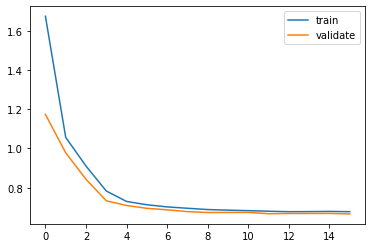

In [24]:
loss_train, loss_val = train()
plot_loss(loss_train, loss_val)

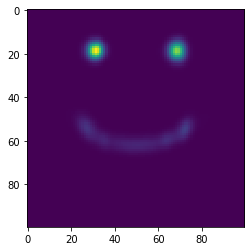

In [25]:
space = np.linspace(-4, 4, 100)
samples = torch.from_numpy(np.array(np.meshgrid(space, space)).T.reshape([-1, 2])).float()
pdf = model(samples).cpu().detach().numpy().reshape(100, 100)
plt.imshow(np.rot90(pdf, 1))

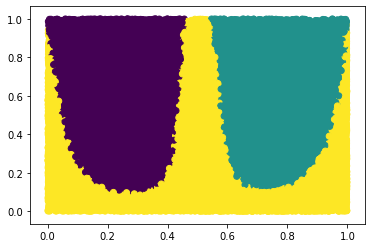

In [26]:
pi1, mu1, sigma1, pi2, mu2, sigma2 = model.params(X_train)
      
z1, z2 = torch.zeros(model.batch,1), torch.zeros(model.batch,1)
      
x1, x2 = X_train[:, :1], X_train[:, 1:]
      
for i in range(model.k):
    z1 += pi1[:,i:i+1] * (Normal(mu1[:,i:i+1].float(),(sigma1[:,i:i+1]).float()).cdf(x1))
    z2 += pi2[:,i:i+1] * (Normal(mu2[:,i:i+1].float(),(sigma2[:,i:i+1]).float()).cdf(x2))

plt.figure()
plt.scatter(z1[:, 0].detach().numpy(), z2[:, 0].detach().numpy(), c=y_train)
plt.show()

In [0]:
def probs_sample(pi, sigmasq, mu, samples):
  N, K = pi.shape
  out = Variable(torch.zeros(N, samples, 1))
  for i in range(N):
    for j in range(samples):
      u = np.random.uniform()
      prob_sum = 0
      for k in range(K):
        prob_sum += pi.data[i, k]
        if u < prob_sum:
          sample = np.random.normal(mu.data[i, k], np.sqrt(sigmasq.data[i, k]))
          out[i, j, 0] = sample
          break
  return out

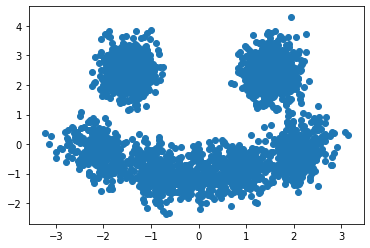

In [28]:
pi1, mu1, sigma1 = model.softmax(model.pi1_.view(1,-1)), model.mu1_.view(1,-1), torch.abs(model.sigma1_).view(1,-1)
p1 = probs_sample(pi1, sigma1, mu1, samples=3000)
pi2, mu2, sigma2 = model.params2(p1)
p2 = probs_sample(pi2[0], sigma2[0], mu2[0], samples=1)
plt.figure()
plt.scatter(p1, p2)
plt.show()

In [0]:
class RealNVP(nn.Module):
    def __init__(self, k=8):
        super(RealNVP, self).__init__()
        self.mask = nn.Parameter(torch.from_numpy(np.array([[0, 1], [1, 0]] * k).astype(np.float32)), requires_grad=False)

        layers1 = []
        for _ in range(k):
            layers1.append(nn.Sequential(nn.Linear(2, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, 2), nn.Tanh()))

        layers2 = []
        for _ in range(k):
            layers2.append(nn.Sequential(nn.Linear(2, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, 2)))
    
        self.t = ModuleList(layers1)
        self.s = ModuleList(layers2)

    def forward(self, x):
        det = x.new_zeros(x.shape[0])
        z = x
        for i in range(len(self.t)):
            s = self.s[i](self.mask[i] * z) * (1 - self.mask[i])
            t = self.t[i](self.mask[i] * z) * (1 - self.mask[i])
            #z = self.mask[i] * z * (1 +) + z * torch.exp(s) - self.mask[i] * z *  + t * (1 - self.mask[i])
            z = self.mask[i] * z + (1 - self.mask[i]) * (z * torch.exp(s) + t)
            det += s.sum(dim=1)
        return z, det

    def __call__(self, x):
        return self.forward(x)

In [0]:
dist = MultivariateNormal(torch.zeros(2), torch.eye(2))

In [0]:
def rloss(x):
    z, logp = x
    return -((dist.log_prob(z) + logp) / 2).mean()

In [0]:
model = RealNVP().float()
batch_size = 512
epochs_cnt = 16
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [0]:
def train2():
    train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(X_val, batch_size=batch_size)
    loss_train, loss_val = [], []

    for epoch in range(epochs_cnt):
        loss_it = []
        
        model.train()
        for batch in train_loader:
            out = model(batch)
            loss = rloss(out)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_it.append(loss.detach().numpy())
        loss_train.append(np.mean(loss_it))
        
        model.eval()
        with torch.no_grad():
            loss_it = []
            for batch in val_loader:
                out = model(batch)
                loss = rloss(out)
                loss_it.append(loss.detach().numpy())
            loss_val.append(np.mean(loss_it))

        print("It: " + str(epoch) + " Train loss: " + str(loss_train[-1]) + " Val loss: " + str(loss_val[-1]))

    loss_values = []
    for batch in test_loader:
        out = model(batch)
        loss = rloss(out)
        loss_values.append(loss.item())

    print("Test loss: " + str(np.mean(np.array(loss_values))))
    return loss_train, loss_val

It: 0 Train loss: 1.2045009 Val loss: 0.88255244
It: 1 Train loss: 0.8537355 Val loss: 0.7903589
It: 2 Train loss: 0.8044521 Val loss: 0.760502
It: 3 Train loss: 0.7882794 Val loss: 0.81868947
It: 4 Train loss: 0.7601647 Val loss: 0.7622278
It: 5 Train loss: 0.75960565 Val loss: 0.7174164
It: 6 Train loss: 0.7437832 Val loss: 0.72801006
It: 7 Train loss: 0.739225 Val loss: 0.73409665
It: 8 Train loss: 0.7384968 Val loss: 0.74239194
It: 9 Train loss: 0.7328567 Val loss: 0.7414421
It: 10 Train loss: 0.7305404 Val loss: 0.7509529
It: 11 Train loss: 0.7234323 Val loss: 0.71385074
It: 12 Train loss: 0.7196317 Val loss: 0.7465786
It: 13 Train loss: 0.723044 Val loss: 0.7353644
It: 14 Train loss: 0.725557 Val loss: 0.7313403
It: 15 Train loss: 0.71278584 Val loss: 0.69192183
Test loss: 0.7057371601462364


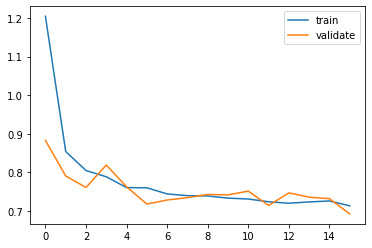

In [34]:
loss_train, loss_val = train2()
plot_loss(loss_train, loss_val)

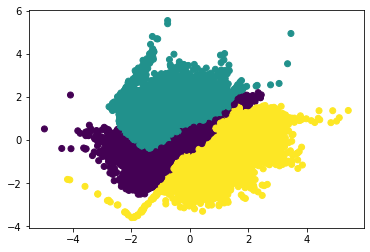

In [35]:
z, _ = model(X_train)
z1, z2 = z[:, 0], z[:, 1]
plt.scatter(z1.detach().numpy(), z2.detach().numpy(), c=y_train)
plt.show()

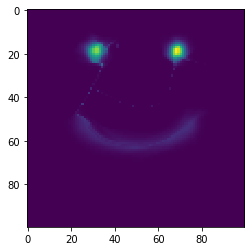

In [36]:
space = np.linspace(-4, 4, 100)
samples = torch.from_numpy(np.array(np.meshgrid(space, space)).T.reshape([-1, 2])).float()
with torch.no_grad():
    z, t = model(samples)
    z = (dist.log_prob(z) + t).exp()
    z = z.cpu().numpy()
    z = z.reshape(100, 100)
        
plt.imshow(np.rot90(z))
plt.show()

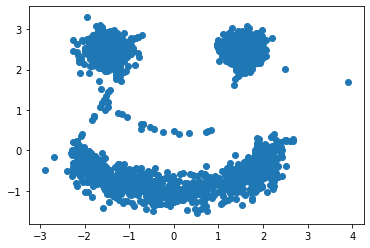

In [37]:
z = dist.sample((3000, 1))
x = z

for i in reversed(range(len(model.t))):
    x_ = model.mask[i] * x
    s = model.s[i](x_) * (1 - model.mask[i])
    t = model.t[i](x_) * (1 - model.mask[i])
    x = (1 - model.mask[i]) * (x - t) * torch.exp(-s) + x_

x1, x2 = x[:, 0, 0], x[:, 0, 1]
plt.scatter(x1.detach().numpy(), x2.detach().numpy())
plt.show()